In [14]:
import os
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input, Multiply, Reshape, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
# ========== CONFIG ==========
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_PHASE_1 = 10
EPOCHS_PHASE_2 = 30
LEARNING_RATE_PHASE_1 = 1e-4
LEARNING_RATE_PHASE_2 = 1e-5
UNFREEZE_LAYERS = 50

In [16]:
BASE_DIR = "/mnt/k/ml/clg_ml/domain_specific_classification"
train_dir = os.path.join(BASE_DIR, "train/skin_diseases")
val_dir = os.path.join(BASE_DIR, "val/skin_diseases")
test_dir = os.path.join(BASE_DIR, "test/skin_diseases")
MODEL_PATH = "skin_diseases_model.h5"
google_images_dir = '/mnt/k/ml/clg_ml/imgs_from_google/domainSpecificClassifier/skin_diseases/'
class_labels = ['benign keratosis like lesion', 'eczema']

In [17]:
# ========== SE BLOCK ==========
def squeeze_excite_block(input_tensor, ratio=16):
    '''Create a squeeze and excitation block'''
    filters = input_tensor.shape[-1]
    se = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
    se = Reshape((1, 1, filters))(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    x = Multiply()([input_tensor, se])
    return x

In [18]:
# ========== DATA ==========
def create_generators():
    train_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    ).flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True)

    val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
    test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
    return train_gen, val_gen, test_gen

In [19]:
# ========== MODEL ==========
def build_model(num_classes):
    base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base.trainable = False  # Phase 1: freeze backbone

    x = base.output
    x = squeeze_excite_block(x)  # <-- Attention block here

    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=base.input, outputs=output), base

In [20]:
# ========== TRAINING ==========
def train_model():
    train_gen, val_gen, test_gen = create_generators()
    model, base_model = build_model(num_classes=2)

    # Phase 1: Train top classifier
    print("🔹 Phase 1: Training classifier head...")
    model.compile(optimizer=Adam(LEARNING_RATE_PHASE_1), loss='categorical_crossentropy', metrics=['accuracy'])

    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
        ReduceLROnPlateau(patience=3, factor=0.2, min_lr=1e-6),
        ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor='val_accuracy', verbose=1)
    ]

    model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS_PHASE_1, callbacks=callbacks)

    # Phase 2: Fine-tuning last N layers
    print("🔹 Phase 2: Fine-tuning base model...")
    base_model.trainable = True
    for layer in base_model.layers[:-UNFREEZE_LAYERS]:
        layer.trainable = False

    model.compile(optimizer=Adam(LEARNING_RATE_PHASE_2), loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS_PHASE_2, callbacks=callbacks)

    # Load best weights before evaluation
    print("📦 Loading best model weights...")
    model.load_weights(MODEL_PATH)

    # Final evaluation
    evaluate_model(model, test_gen)

In [21]:
def evaluate_model(model, test_gen):
    print("📊 Evaluating model on test set...")
    test_gen.reset()
    
    y_true = test_gen.classes
    class_labels = list(test_gen.class_indices.keys())
    
    # Predict probabilities
    y_pred_probs = model.predict(test_gen, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Accuracy
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    print(f"\n✅ Test Accuracy: {accuracy:.4f}\n")

    # Classification Report
    print("📄 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    # Confusion Matrix
    print("🔁 Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

In [22]:
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize
    return img_array

In [23]:
def classify_images():
    model = tf.keras.models.load_model(MODEL_PATH)
    print(f"🔍 Loaded model from: {MODEL_PATH}")

    image_files = [f for f in os.listdir(google_images_dir)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.webp'))]

    if not image_files:
        print("❌ No images found in directory.")
        return

    print(f"\n🧪 Classifying {len(image_files)} images from: {google_images_dir}\n")

    for img_file in sorted(image_files):
        img_path = os.path.join(google_images_dir, img_file)
        img_array = preprocess_image(img_path)

        preds = model.predict(img_array, verbose=0)
        pred_index = np.argmax(preds[0])
        confidence = preds[0][pred_index] * 100

        predicted_class = class_labels[pred_index]
        print(f"{img_file} → Predicted: {predicted_class} ({confidence:.2f}%)")

Found 3028 images belonging to 2 classes.
Found 364 images belonging to 2 classes.
Found 360 images belonging to 2 classes.


I0000 00:00:1760069480.907348     799 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3618 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


🔹 Phase 1: Training classifier head...


/mnt/k/ml/clg_ml/venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


2025-10-10 09:41:34.659192: I external/local_xla/xla/service/service.cc:163] XLA service 0x7ff544001820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-10 09:41:34.659236: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 6GB Laptop GPU, Compute Capability 8.6
2025-10-10 09:41:35.178798: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-10 09:41:37.877966: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300
2025-10-10 09:41:37.189596: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-10 09:41

12/95 ━━━━━━━━━━━━━━━━━━━━ 42s 513ms/step - accuracy: 0.4425 - loss: 1.3800

2025-10-10 09:42:12.074235: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-10 09:42:12.074311: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-10 09:42:14.043542: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11943', 16 bytes spill stores, 16 bytes spill loads



95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step - accuracy: 0.6766 - loss: 0.7233

2025-10-10 09:43:22.728631: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-10 09:43:23.114950: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3399', 8 bytes spill stores, 8 bytes spill loads

2025-10-10 09:43:23.478409: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3406', 20 bytes spill stores, 20 bytes spill loads

2025-10-10 09:43:36.185512: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3399', 8 bytes


Epoch 1: val_accuracy improved from None to 0.99176, saving model to skin_diseases_model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.8382 - loss: 0.3862 - val_accuracy: 0.9918 - val_loss: 0.2119 - learning_rate: 1.0000e-04
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.9739 - loss: 0.0939
Epoch 2: val_accuracy improved from 0.99176 to 0.99725, saving model to skin_diseases_model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 40s 421ms/step - accuracy: 0.9779 - loss: 0.0804 - val_accuracy: 0.9973 - val_loss: 0.0790 - learning_rate: 1.0000e-04
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9800 - loss: 0.0619
Epoch 3: val_accuracy did not improve from 0.99725
95/95 ━━━━━━━━━━━━━━━━━━━━ 43s 454ms/step - accuracy: 0.9855 - loss: 0.0507 - val_accuracy: 0.9973 - val_loss: 0.0364 - learning_rate: 1.0000e-04
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.9897 - loss: 0.0404
Epoch 4: val_accuracy did not improve from 0.99725
95/95 ━━━━━━━━━━━━━━━━━━━━ 41s 431ms/step - accuracy: 0.9891 - loss: 0.0384 - val_accuracy: 0.9973 - val_loss: 0.0164 - learning_rate: 1.0000e-04
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9940 - loss: 0.0262
Epoch 5: val_accuracy improved from 0.99725 to 1.00000, saving model to skin_diseases_model.h5


95/95 ━━━━━━━━━━━━━━━━━━━━ 41s 434ms/step - accuracy: 0.9937 - loss: 0.0259 - val_accuracy: 1.0000 - val_loss: 0.0108 - learning_rate: 1.0000e-04
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.9923 - loss: 0.0283
Epoch 6: val_accuracy did not improve from 1.00000
95/95 ━━━━━━━━━━━━━━━━━━━━ 63s 660ms/step - accuracy: 0.9914 - loss: 0.0287 - val_accuracy: 1.0000 - val_loss: 0.0053 - learning_rate: 1.0000e-04
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9923 - loss: 0.0298
Epoch 7: val_accuracy did not improve from 1.00000
95/95 ━━━━━━━━━━━━━━━━━━━━ 42s 440ms/step - accuracy: 0.9941 - loss: 0.0224 - val_accuracy: 1.0000 - val_loss: 0.0045 - learning_rate: 1.0000e-04
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.9938 - loss: 0.0187
Epoch 8: val_accuracy did not improve from 1.00000
95/95 ━━━━━━━━━━━━━━━━━━━━ 37s 393ms/step - accuracy: 0.9934 - loss: 0.0202 - val_accuracy: 1.0000 - val_loss: 0.0023 - learning_rate: 1.0000e-04
Epoch

2025-10-10 10:10:49.362757: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3344', 8 bytes spill stores, 8 bytes spill loads



12/12 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step

✅ Test Accuracy: 0.9889

📄 Classification Report:
                  precision    recall  f1-score   support

benign_keratosis       0.98      1.00      0.99       204
          eczema       1.00      0.97      0.99       156

        accuracy                           0.99       360
       macro avg       0.99      0.99      0.99       360
    weighted avg       0.99      0.99      0.99       360

🔁 Confusion Matrix:


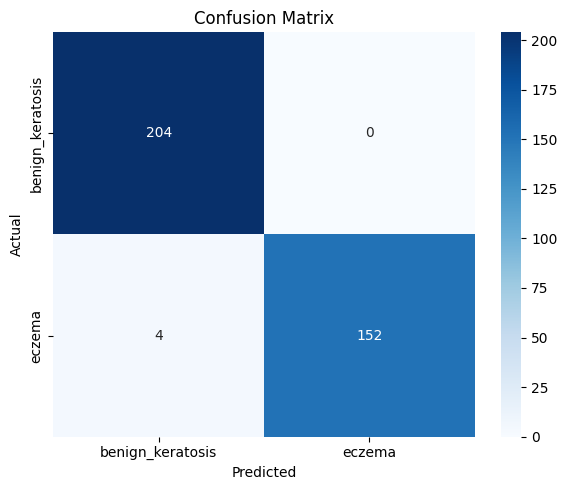

In [24]:
if __name__ == "__main__":
    train_model()

In [31]:
classify_images()

🔍 Loaded model from: skin_diseases_model.h5

🧪 Classifying 12 images from: /mnt/k/ml/clg_ml/imgs_from_google/domainSpecificClassifier/skin_diseases/

be_ke_le.jpeg → Predicted: benign keratosis like lesion (71.15%)
be_ke_le2.jpg → Predicted: eczema (82.63%)
be_ke_le3.jpg → Predicted: benign keratosis like lesion (72.98%)
be_ke_le4.jpg → Predicted: benign keratosis like lesion (100.00%)
be_ke_le5.jpg → Predicted: benign keratosis like lesion (99.91%)
be_ke_le6.jpg → Predicted: benign keratosis like lesion (99.99%)
be_ke_le7.webp → Predicted: eczema (99.32%)
be_ke_le8.jpg → Predicted: benign keratosis like lesion (90.31%)
ecz9 (157).jpg → Predicted: eczema (99.99%)
ecz9 (158).jpg → Predicted: eczema (99.64%)
ecz9 (159).jpg → Predicted: eczema (99.92%)
ecz9 (160).jpg → Predicted: eczema (99.85%)
